# INFO 602 Final Project - InfoSec Open Source Intelligence (OSINT) Categorization
Michael Poff

## Executive Summary



In [2]:
import warnings
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import string
from IPython.display import display, Markdown
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import *
from imblearn.pipeline import Pipeline
from sklearn.neural_network import *
from sklearn.ensemble import *
from sklearn.naive_bayes import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss, confusion_matrix, silhouette_score
from sentence_transformers import SentenceTransformer
import numpy as np
import plotly_express as px
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import tqdm


warnings.filterwarnings('ignore')

## Data

In [3]:
data = pd.read_excel('./data/article_data.xlsx')
display (Markdown(f"The dataset contains {len(data)} data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:"))

The dataset contains 345 data points, each of which represents an article scraped from a number of information security news and intelligence providers (listed below). Each row contains the following features:

### Data Dictionary   

- Title: The title of the article.
-   Content: The article contents.
-   Category: A manually labeled category label, chosen from one of nine options (listed below).
-   Zero-Shot Category: A label applied by the [HuggingFace zero-shot classification transformer](https://huggingface.co/tasks/zero-shot-classification) using the same set of nine options.
-   Zero-Shot Match: Indicates whether the zero-shot classification corresponds with the manual category assignment, expressed as TRUE or FALSE.

### Categories

**1. Vulnerability Reports**
Articles that detail specific software or hardware vulnerabilities, often including technical descriptions, severity assessments, and potential impact.

Classification Guidance:
-  Mentions of CVE identifiers (Common Vulnerabilities and Exposures).
-  Technical analysis or proof-of-concept code.
-  Discussions on vulnerability scores (e.g., CVSS scores).
-  Mention of affected platforms, software, or hardware.

**2. Security Updates and Patches**
These articles focus on the release of security updates, patches, or workarounds intended to fix vulnerabilities or improve security.

Classification Guidance:
-  Announcements from software or hardware vendors.
-  Instructions or recommendations for patching or updating systems.
-  Discussions of specific issues fixed by the update or patch.
-  References to advisory publications from vendors or security organizations.

**3. Emerging Threats and Attack Techniques**
Articles covering new or evolving cybersecurity threats, including novel attack vectors, malware, ransomware, or phishing campaigns.

Classification Guidance:
-  Descriptions of novel or evolving attack methodologies or exploit techniques.
-  Analysis of threat actors or campaigns.
-  Statistics or reports on the rise of specific threats.
-  Case studies or examples of recent attacks.
-  Focus on novel or evolving threat.
-  Novel research into system vulnerabilities without technical details or classifications (CVE).

**4. Regulatory Changes and Compliance**
Coverage of changes in cybersecurity laws, regulations, or standards, and how organizations can achieve compliance.

Classification Guidance:
-  Mention of specific legal acts, regulations, or compliance frameworks (e.g., GDPR, CCPA, HIPAA, SOC 2).
-  Guidance or advice on compliance strategies.
-  Analysis of the impact of regulatory changes on businesses or industries.
-  Expert commentary or interviews with legal or compliance professionals.

**5. Data Breaches and Security Incidents**
Reports on specific incidents where data has been exposed, stolen, or otherwise compromised, including details on the nature of the breach, affected parties, and aftermath. May be a breach or incident involving a wide-ranging scope (single company, to thousands of devices). Not every mention of an incident automatically classifies in this category, the distinction depends on the article's focus, depth of coverage regarding the specific incident, and the context in which the incident is mentioned.

Classification Guidance:
-  Specific details of the incident (what, when, how).
-  Information on the data compromised (types of data, number of records).
-  Responses or statements from the affected organization.
-  Analysis of the breach’s impact or lessons learned.
-  Specific details of an incident.

**6. News and Industry Updates**
General news related to the infosec industry, including market trends, mergers and acquisitions, or significant appointments and departures.

Classification Guidance:
-  Coverage of significant events or changes within infosec companies or organizations.
-  Market analysis or trends in cybersecurity.
-  Announcements of significant new technologies or products.
-  Profiles or interviews with industry leaders.
-  Specific government actions against individuals or groups.

**7. Marketing**
Articles or content primarily aimed at promoting specific cybersecurity products, services, or brands.

Classification Guidance:
-  Direct mentions of product features or benefits.
-  Comparisons with competing products or services.
-  Testimonials, case studies, or customer stories.
-  Content that focuses more on persuasion rather than providing objective information or analysis.

### Sources
-   [The Hacker News](https://thehackernews.com/)
-   [Bleeping Computer](https://www.bleepingcomputer.com/)
-   [Dark Reading](https://www.darkreading.com/)
-   [CISA Advisories](https://www.cisa.gov/news-events/cybersecurity-advisories)
-   [The Register - Security](https://www.theregister.com/security/)
-  [Cybersecurity Dive](https://www.cybersecuritydive.com/)

### Notes
The article data were scraped using the Python library [Trafilatura](https://github.com/adbar/trafilatura) which does a good job of scraping content and metadata from article web pages, however some results are skewed. Rather than manually refine the data, the model should learn to ignore this extraneous text.

## Preprocessing

This section tokenizes the contents of each article into words and sentences. Preprocessing on the data includes normalizing all content to lowercase, replacing common abbreviations that may be confused for stop words, removing URLs, removing punctuation, removing stop words, removing non-ascii characters, and [lemmatizing](https://en.wikipedia.org/wiki/Lemmatization) the words, and removing single character tokens. Finally, all words are joined into a single string and added as another feature in the dataset. 

Thanks to Afham Fardeen for his [guide](https://machinelearningknowledge.ai/11-techniques-of-text-preprocessing-using-nltk-in-python/) to performing text preprocessing.

In [4]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_lg')

# Add custom stop words
# Removing security, cybersecurity, and data to see if that improves model performance (worth noting after the fact that this didn't improve accuracy, but improved recall across the board by about 20%.
custom_stopwords = {'said', 'say','use','include','security','cybersecurity','data','datum'}
for word in custom_stopwords:
    nlp.Defaults.stop_words.add(word)

# Add an ID column to the data for better tracking
data['ID'] = range(0, len(data))

# Convert the data in the content column to lowercase
data['content'] = data['content'].str.lower()

# Perform sentence tokenization
def sentence_tokenize(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences
data['sentences'] = data['content'].apply(sentence_tokenize)

# Handle abbreviations in the data that align with stopwords
def replace_abbreviations(text):
    replacements = {'u.s.': 'usa', 'u.s': 'usa'}
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text
data['content'] = data['content'].apply(replace_abbreviations)

# Remove urls from the data
def remove_urls(text):
    # Regex pattern for matching URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs with an empty string
    return re.sub(url_pattern, '', text)

# Apply the URL removal function before processing the text with spaCy
data['content'] = data['content'].apply(remove_urls)

def remove_punctuation_from_text(text):
    # Create a translation table where each punctuation mark is mapped to a space
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    # Use the translation table to replace punctuation with spaces in the text
    return text.translate(table)

# Assuming 'data' is your DataFrame and 'content' is the column with text to process
data['content'] = data['content'].apply(remove_punctuation_from_text)

# Function to process text with spaCy, incorporating tokenization, stop word removal, lemmatization, and non-ASCII removal
def process_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_ascii and not token.is_punct:
            if token.lemma_.lower() == "datum": # some instances of the word data were being lematized to datum and others were not, normalizing on the word data rather than datum.
                token.lemma_ = "data"
                
            tokens.append(token.lemma_.lower())
    return tokens

data['words'] = data['content'].apply(process_text)

# Remove tokens that are a single character long
def remove_short_tokens(text):
    result = []
    for word in text:
        if len(word) > 1:
            result.append(word)
    return result
data['words'] = data['words'].apply(remove_short_tokens)

data['processed_content'] = data['words'].apply(lambda x: ' '.join(x))

## Exploratory Data Analysis

### Data Preview
First, a quick look at a row of data. This is limited to a single row because the contents are quite large.

In [5]:
data.head(1).style.set_properties(**{'background-color': 'black', 
                                   'color': 'white', 
                                   'border-color': 'gray'})

,title,content,zero-shot category,category,zero-shot match,ID,sentences,words,processed_content
0,CISA Warns of Active Exploitation Apple iOS and macOS Vulnerability,the usa cybersecurity and infrastructure security agency cisa on wednesday added a high severity flaw impacting ios ipados macos tvos and watchos to its known exploited vulnerabilities kev catalog based on evidence of active exploitation the vulnerability tracked as cve 2022 48618 cvss score 7 8 concerns a bug in the kernel component an attacker with arbitrary read and write capability may be able to bypass pointer authentication apple said in an advisory adding the issue may have been exploited against versions of ios released before ios 15 7 1 the iphone maker said the problem was addressed with improved checks it s currently not known how the vulnerability is being weaponized in real world attacks interestingly patches for the flaw were released on december 13 2022 with the release of ios 16 2 ipados 16 2 macos ventura 13 1 tvos 16 2 and watchos 9 2 although it was only publicly disclosed more than a year later on january 9 2024 it s worth noting that apple did resolve a similar flaw in the kernel cve 2022 32844 cvss score 6 3 in ios 15 6 and ipados 15 6 which was shipped on july 20 2022 it s not immediately clear if the two vulnerabilities are related an app with arbitrary kernel read and write capability may be able to bypass pointer authentication the company said at the time a logic issue was addressed with improved state management in light of the active exploitation of cve 2022 48618 cisa is recommending that federal civilian executive branch fceb agencies apply the fixes by february 21 2024 the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine cve 2024 23222 cvss score 8 8 to include its apple vision pro headset the fix is available in visionos 1 0 2,security updates and patches,vulnerability reports,False,0,"['the u.s. cybersecurity and infrastructure security agency (cisa) on wednesday added a high-severity flaw impacting ios, ipados, macos, tvos, and watchos to its known exploited vulnerabilities (kev) catalog, based on evidence of active exploitation.the vulnerability, tracked as cve-2022-48618 (cvss score: 7.8), concerns a bug in the kernel component.', '""an attacker with arbitrary read and write capability may be able to bypass pointer authentication,"" apple said in an advisory, adding the issue ""may have been exploited against versions of ios released before ios 15.7.1.""the iphone maker said the problem was addressed with improved checks.', ""it's currently not known how the vulnerability is being weaponized in real-world attacks.interestingly, patches for the flaw were released on december 13, 2022, with the release of ios 16.2, ipados 16.2, macos ventura 13.1, tvos 16.2, and watchos 9.2, although it was only publicly disclosed more than a year later on january 9, 2024.it's worth noting that apple did resolve a similar flaw in the kernel (cve-2022-32844, cvss score: 6.3) in ios 15.6 and ipados 15.6, which was shipped on july 20, 2022."", ""it's not immediately clear if the two vulnerabilities are related."", '""an app with arbitrary kernel read and write capability may be able to bypass pointer authentication,"" the company said at the time.', '""a logic issue was addressed with improved state management.', '""in light of the active exploitation of cve-2022-48618, cisa is recommending that federal civilian executive branch (fceb) agencies apply the fixes by february 21, 2024.the development also comes as apple expanded patches for an actively exploited security flaw in the webkit browser engine (cve-2024-23222, cvss score: 8.8) to include its apple vision pro headset.', 'the fix is available in visionos 1.0.2.']","['usa', 'infrastructure', 'agency', 'cisa', 'wednesday', 'add', 'high', 'severity', 'flaw', 'impact', 'ios', 'ipados', 'macos', 'tvo', 'watchos', 'known', 'exploit'

### Categories
This is a simple count of how many articles there are per category.

In [6]:
data['category'].value_counts().reset_index()

,category,count
0,emerging threats and attack techniques,92
1,news and industry updates,91
2,data breaches and security incidents,47
3,marketing,33
4,regulatory changes and compliance,33
5,security updates and patches,29
6,vulnerability reports,20


### Zero-Shot vs. Manual Classification
This section demonstrates the effectiveness of zero-shot classification versus manual classification.


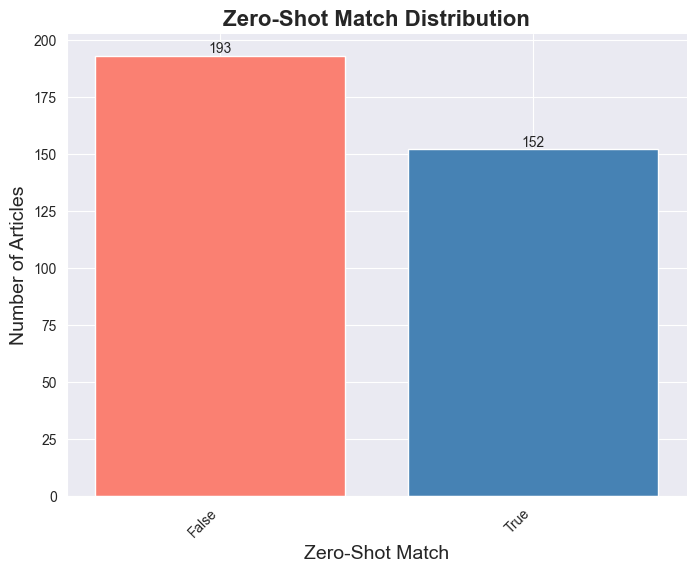

This plot demonstrates that zero-shot classification correctly classifies articles 44.06% of the time. This provides a good benchmark for our model to compare it against a deep neural network with a generalized task.

In [7]:
data['zero-shot match'] = data['zero-shot match'].astype(str)
grouped_data = data.groupby('zero-shot match').size().reset_index(name='n')

grouped_data.head(2)

colors = ['steelblue' if x == 'True' else 'salmon' for x in grouped_data['zero-shot match']]

# Creating the plot
plt.figure(figsize=(8, 6))
bars = plt.bar(grouped_data['zero-shot match'], grouped_data['n'], color=colors)

# Adding text labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

# Customizing the plot
plt.title('Zero-Shot Match Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Zero-Shot Match', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()

# Show plot
plt.show()


true_count = grouped_data.loc[grouped_data['zero-shot match'] == 'True', 'n'].item()
display(Markdown(f"This plot demonstrates that zero-shot classification correctly classifies articles {(true_count/len(data))*100:.2f}% of the time. This provides a good benchmark for our model to compare it against a deep neural network with a generalized task."
))

### Word Clouds
These word clouds distill the core themes across different cybersecurity categories, highlighting key terms. They offer a quick visual summary of the most discussed topics in the field.

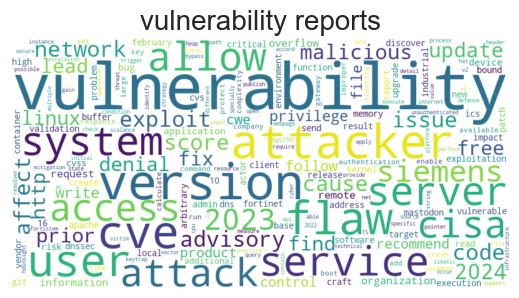

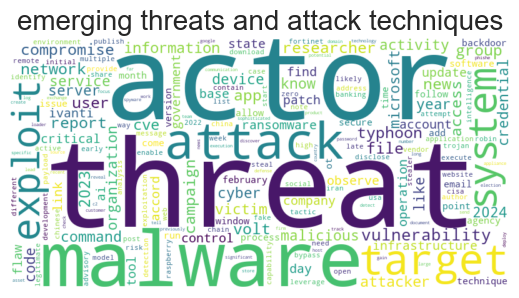

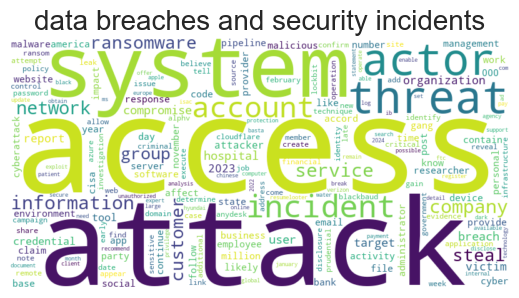

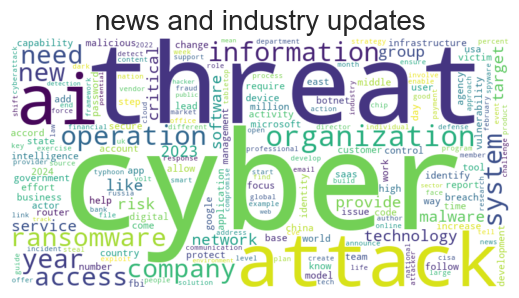

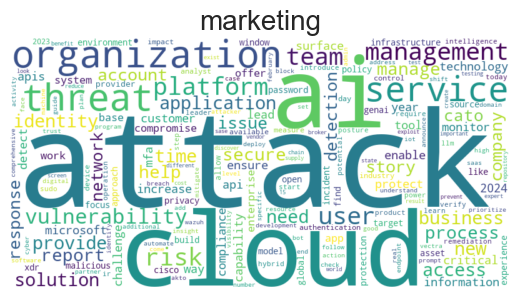

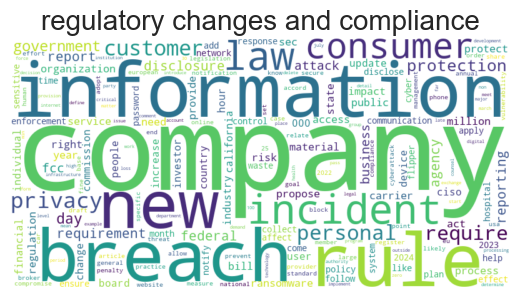

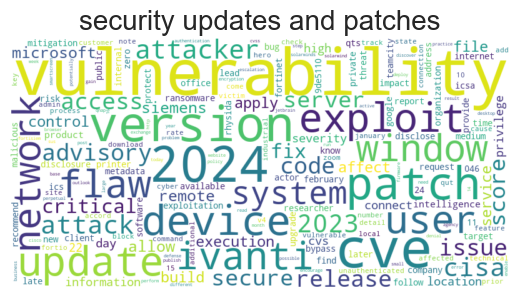

In [8]:
# Expand the list of words into a new row for each word
data_clean = data.explode('words').rename(columns={'words': 'word'})
data_clean = data_clean[data_clean['word'] != ""]  # Remove empty words

# Calculate word frequencies by category
word_frequencies_by_category = data_clean.groupby(['category', 'word']).size().reset_index(name='n')

# Iterate through each unique category to generate word clouds
for category in data_clean['category'].unique():
    # Filter data for the current category
    cat_data = word_frequencies_by_category[word_frequencies_by_category['category'] == category]
    
    # Generate a word cloud
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(dict(zip(cat_data['word'], cat_data['n'])))
    
    # Plotting the WordCloud                    
    plt.figure(figsize = (5, 2.5), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    
    plt.title(category, fontsize=20)
    plt.show()

## Fitting Models

### Method 1: Bag of Words using TF-IDF
In this model pipeline, a series of steps are executed to pre-process the data, address class imbalance, and finally classify the data using a neural network.

1.  **Vectorization** *('vect', CountVectorizer())*: This first step uses a CountVectorizer to convert data['processed_content'] into a matrix of token counts by breacking the test into words (or tokens) and counting the occurence of each token in the dataset. The CountVectorizer focuses on the frequency of words used across documents.
2.  **Term Frequency Normalization** *('tfidf', TfidfTransformer(use_idf=False))*: After the initial vectorization step, the pipeline employs the TfidfTransformer without inverse document frequency (use_idf=False). This adjustment signifies that the transformer will not calculate the IDF values for each word across the documents. Without IDF, this step focuses on scaling the frequency of words withint each document to a standard range, ensuring that the length of the document does not disprpoportionately influence how it's understood or represented by the model.
3.  **Class Imbalance Handling** *('smote', SMOTE(random_state=42))*: The [SMOTE (Synthetic Minority Over-sampling Technique)](https://www.wikiwand.com/en/Oversampling_and_undersampling_in_data_analysis#SMOTE) step addresses class imbalance in the training data. Class imbalance can significantly affect the performance of machine learning models, leading to a bias towards the majority class; and as previously identified, this dataset suffers greatly from class imbalance. SMOTE generates synthetic samples from the minority class to create a balanced dataset, improving the classifier's ability to learn from an evenly distributed dataset.
4.  **Classification** *('clf', MLPClassifier(random_state=42))*: The final step in the pipeline employs an MLPClassifier, a type of neural network known as a Multi-Layer Perceptron. This classifier uses backpropagation for training, adjusting weights to minimize the error between predicted and actual classifications. The MLPClassifier is capable of capturing complex relationships in the data through its hidden layers, making it a powerful tool for classification tasks.

A fair bit of hyperparameter tuning took place, including the use of GridSearchCV to perform an exhaustive search for the best hyperparameter values given a range of values for each. The tables below show a range of models attempted along with hyperparameter tunings that gave the best results for each classifier.

These are the classifiers and hyperparameter settings that yielded the best accuracy and weighted precision for each classifier, ultimately MLPClassifier() and MultinomialNB(alpha=0.1) proved the best two.

MLPClassifier()
ComplementNB(alpha=0.1)
RandomForestClassifier(criterion="log_loss", random_state=42)
MultinomialNB(alpha=0.1)
GradientBoostingClassifier(max_depth=4, random_state=42) 


#### Results

In [9]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    data['processed_content'],
    data['category'],
    test_size=.25,
    random_state=42,
    stratify=data['category']
)

# Build a function for fitting the model on different classifiers.
def benchmark(clf, smote):
    if smote:
        display(Markdown(f"{clf.__class__.__name__} with SMOTE"))
    else:
        display(Markdown(f"{clf.__class__.__name__}"))
    
    # Model Pipeline
    if smote:
        text_clf = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('smote', SMOTE(random_state=42)),
            ('clf', clf ),
        ])
    else:
        text_clf = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer(use_idf=False)),
            ('clf', clf ),
        ])
    
    # Train the classifier
    text_clf.fit(X_train, y_train)
    
    # Evaluate the classifier
    predicted = text_clf.predict(X_test)
    predicted_probs = text_clf.predict_proba(X_test)
    predicted_probs = np.divide(predicted_probs, np.sum(predicted_probs, axis=1)[:, np.newaxis])

    print(classification_report(y_test, predicted))
    loss = log_loss(y_test, predicted_probs)
    print(f"Cross-Entropy Loss / Log Loss: {loss}")
    
for clf, smote in {
    (MLPClassifier(random_state=42), True),
    (MultinomialNB(alpha=0.001), True)
}:
    benchmark(clf,smote)

MLPClassifier with SMOTE

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.83      0.83      0.83        12
emerging threats and attack techniques       0.79      0.83      0.81        23
                             marketing       0.50      0.56      0.53         9
             news and industry updates       0.65      0.65      0.65        23
     regulatory changes and compliance       0.83      0.62      0.71         8
          security updates and patches       0.75      0.86      0.80         7
                 vulnerability reports       0.75      0.60      0.67         5

                              accuracy                           0.72        87
                             macro avg       0.73      0.71      0.71        87
                          weighted avg       0.73      0.72      0.72        87

Cross-Entropy Loss / Log Loss: 0.7743061198073148


MultinomialNB with SMOTE

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.80      0.67      0.73        12
emerging threats and attack techniques       0.71      0.87      0.78        23
                             marketing       0.60      0.33      0.43         9
             news and industry updates       0.56      0.78      0.65        23
     regulatory changes and compliance       1.00      0.50      0.67         8
          security updates and patches       0.75      0.43      0.55         7
                 vulnerability reports       0.75      0.60      0.67         5

                              accuracy                           0.68        87
                             macro avg       0.74      0.60      0.64        87
                          weighted avg       0.71      0.68      0.67        87

Cross-Entropy Loss / Log Loss: 1.6199747174207724


#### Evaluation

**Interpreting the Metrics**
The MultinomialNB classifier correctly identifies the category of articles 68% of the time. On average, when it predicts an article belongs to a specific category, it is correct 69% of the time. Furthermore, it successfully identifies 68% of all articles that actually belong to each category.

The MLPClassifier accurately determines the category of articles 72% of the time. When it predicts an article belongs to a specific category, it is correct approximately 74% of the time. Additionally, it successfully identifies around 72% of all articles that truly belong to each category.

**Comparison**
While these models both do a good job of classifying the articles, the MLPClassifier is approximately 5.88% better in terms of accuracy compared to the MultinomialNB classifier. The MultinomialNB was able to achieve a slightly higher precision on marketing, however, the MLPClassifier is better overall, and the deficiency in the marketing category may be solved by adding more data. Additionally, the confidence and reliability of the MLPClassifier's predictions are notably higher. This means that not only does it classify articles more accurately, but its estimates about how likely each article belongs to its predicted category are closer to reality, suggesting it makes its decisions with a better understanding of the actual risks of misclassification. Given these considerations, the MLPClassifier emerges as the superior choice for this task. Its blend of higher accuracy, balanced performance across categories, and more confident predictions make it the more robust and dependable model for classifying cybersecurity articles.

**Final Thoughts and Next Steps**
These models excel beyond zero-shot classification in accuracy, showing advancement in article categorization. Yet, to fully leverage their potential in real-world applications, further improvements in accuracy, precision, and recall are essential. Enhancing these metrics reduces the need for manual corrections and ensures reliable system performance for accurate content identification and categorization. 

With TF-IDF now seen as outdated for generating embeddings, modern techniques like Word2Vec or Sentence-BERT (SBERT) offer paths to greater accuracy. Word2Vec excels at analyzing word context within text but lacks in capturing sentence or paragraph-level meanings. SBERT, building on the BERT model, is designed for sentence and document-level embeddings, providing a deeper context understanding. This feature, combined with SBERT's efficiency and ease of integration, makes it the chosen method for our next model development, aiming at improving text classification and categorization tasks.
 
The decision to adopt SBERT is driven by its capability to comprehend the intricacies of sentences and documents, which is crucial for accurately categorizing articles. This approach aligns with our objective to enhance the model's performance in distinguishing between different types of content effectively. By utilizing SBERT's advanced embedding capabilities, we anticipate a significant improvement in our model's ability to classify articles with higher accuracy, precision, and recall.

### Method 2: SBERT Embeddings


*Thanks to [Thomas Wong](https://towardsdatascience.com/easily-get-high-quality-embeddings-with-sentencetransformers-c61c0169864b) and [Mariya Mansurova](https://towardsdatascience.com/text-embeddings-comprehensive-guide-afd97fce8fb5) for their guidance on working with SBERT embeddings*

In [10]:
%%capture
sbert_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1', device='cuda')

In [11]:
# Create a dataframe from the sentence tokens and categories
sdata = data[['ID','sentences', 'category']]

def get_embeddings(sentences):
    """
    Get embeddings for a list of sentences.
    The final embeddings is the mean of all sentence embeddings.
    
    :param sentences: list of str. Input sentences.
    :return: np.array. The mean embeddings of the sentences.
    """
    # Ensure that the input is a list of sentences
    if not isinstance(sentences, list):
        raise ValueError("Input must be a list of sentences")
    
    # Encode the sentences using the model and calculate the mean embeddings
    return np.mean(sbert_model.encode(sentences), axis=0)

sdata['embeddings'] = sdata['sentences'].apply(get_embeddings)

In [13]:
X = np.stack(sdata['embeddings'].values)
y = sdata['category'].values

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.25,
    random_state=42,
    stratify=y
)

def benchmark(clf):
    display(Markdown(clf.__class__.__name__))
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    predicted_probs = clf.predict_proba(X_test)
    predicted_probs = np.divide(predicted_probs, np.sum(predicted_probs, axis=1)[:, np.newaxis])
    print(classification_report(y_test, predicted))
    loss = log_loss(y_test, predicted_probs)
    print(f"Cross-Entropy Loss / Log Loss: {loss}")
    
    cm = confusion_matrix(y_test, predicted)

    fig = px.imshow(
      cm, x = clf.classes_,
      y = clf.classes_, text_auto='d', 
      aspect="auto", 
      labels=dict(
          x="predicted label", y="true label", 
          color="cases"), 
      color_continuous_scale='pubugn',
      title = '<b>Confusion matrix</b>', height = 550)
    
    fig.show()
    
    
classifiers = {
    MLPClassifier(random_state=42),
    LogisticRegression()
}

for clf in classifiers:
    benchmark(clf)

MLPClassifier

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.69      0.75      0.72        12
emerging threats and attack techniques       0.65      0.87      0.74        23
                             marketing       0.50      0.33      0.40         9
             news and industry updates       0.75      0.65      0.70        23
     regulatory changes and compliance       1.00      0.88      0.93         8
          security updates and patches       0.67      0.29      0.40         7
                 vulnerability reports       0.43      0.60      0.50         5

                              accuracy                           0.68        87
                             macro avg       0.67      0.62      0.63        87
                          weighted avg       0.69      0.68      0.67        87

Cross-Entropy Loss / Log Loss: 1.1307634937599076


LogisticRegression

                                        precision    recall  f1-score   support

  data breaches and security incidents       0.71      0.83      0.77        12
emerging threats and attack techniques       0.62      0.91      0.74        23
                             marketing       0.67      0.44      0.53         9
             news and industry updates       0.74      0.61      0.67        23
     regulatory changes and compliance       1.00      0.75      0.86         8
          security updates and patches       1.00      0.14      0.25         7
                 vulnerability reports       0.43      0.60      0.50         5

                              accuracy                           0.68        87
                             macro avg       0.74      0.61      0.62        87
                          weighted avg       0.72      0.68      0.66        87

Cross-Entropy Loss / Log Loss: 0.851806913021119
